In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
from dtaidistance import dtw
import random
from datetime import timedelta
from pandas.tseries.offsets import DateOffset
from scipy.stats import percentileofscore, zscore
import ta
import os
from typing import List, Tuple

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [3]:
file_path = 'BTCUSDT.csv'
data = pd.read_csv(file_path)

data['datetime'] = pd.to_datetime(data['datetime'])
data.set_index('datetime', inplace=True)

train_start = '2020-01-01 00:00:00'
train_end   = '2021-12-31 23:59:00'
test_start  = '2020-09-01 00:00:00'
test_end    = '2021-07-30 23:59:00'

train_data = data.loc[train_start:train_end]
test_data  = data.loc[test_start:test_end]

scaler = StandardScaler()
train_scaled = scaler.fit_transform(train_data[['close']])
test_scaled  = scaler.transform(test_data[['close']])

train_torch = torch.tensor(train_scaled, dtype=torch.float32)
test_torch  = torch.tensor(test_scaled,  dtype=torch.float32)

/tmp/ipykernel_12657/1352903863.py:2: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(file_path)


In [55]:
def mark_extremes_advanced(prices: List[float],
                           threshold_abs: float = 0.0,
                           threshold_pct: float = 0.03,
                           use_pct: bool = True,
                           dynamic_threshold: bool = False,
                           vol_window: int = 10,
                           vol_multiplier: float = 1.0,
                           confirmation_period: int = 1) -> List[Tuple[int, str]]:
    """
    Identify turning points (peaks and troughs) in a price series using an advanced zigzag approach.
    
    In this version, a turning point is detected only after a reversal condition is confirmed
    for a number of consecutive bars (confirmation_period). In addition, the threshold for a reversal
    can be based on either a fixed percentage/absolute level or (optionally) be dynamically adjusted 
    based on recent volatility.
    
    Parameters:
        prices (List[float]): List of price values.
        threshold_abs (float): Fixed absolute threshold (if use_pct is False).
        threshold_pct (float): Percentage threshold (e.g. 0.03 for 3%) used if use_pct is True.
        use_pct (bool): If True, the base threshold is computed as threshold_pct * current_price.
        dynamic_threshold (bool): If True, adjust the threshold based on recent volatility.
        vol_window (int): Number of bars to compute volatility if dynamic_threshold is True.
        vol_multiplier (float): Multiplier for volatility to form a dynamic threshold.
        confirmation_period (int): Number of consecutive bars that must confirm a reversal before marking it.
    
    Returns:
        List[Tuple[int, str]]: A list of tuples where each tuple is (index, type) and type is either 'peak' or 'trough'.
    """
    if not prices:
        return []
    
    turning_points: List[Tuple[int, str]] = []
    
    # Initialize extremes with the first price.
    last_min = prices[0]
    last_max = prices[0]
    last_min_idx = 0
    last_max_idx = 0

    # Trend indicator: True means an uptrend (so the last extreme was a minimum)
    # False means a downtrend (last extreme was a maximum). None means not yet established.
    trend = None

    i = 1
    n = len(prices)
    
    while i < n:
        price = prices[i]
        
        if dynamic_threshold:
            if i < vol_window:
                i += 1
                continue
            recent_changes = np.diff(prices[i-vol_window:i+1])
            volatility = np.std(recent_changes)
            dynamic_thresh = vol_multiplier * volatility
            threshold = max(threshold_abs, dynamic_thresh)
        else:
            threshold = threshold_abs if not use_pct else threshold_pct * prices[i]
        # --- Update current extremes ---
        if price > last_max:
            last_max = price
            last_max_idx = i
        if price < last_min:
            last_min = price
            last_min_idx = i
        # --- Establish the initial trend if not set ---
        if trend is None:
            if last_max - prices[0] > threshold:
                trend = True   # Uptrend is established (price rose from the first bar)
            elif prices[0] - last_min > threshold:
                trend = False  # Downtrend is established
            # Else, trend remains undefined.
        # --- Check for reversal conditions with confirmation ---
        # In an uptrend, a sufficient drop from the last maximum signals a potential reversal.
        if trend is True and (last_max - price > threshold):
            confirm = True
            for j in range(i, min(i + confirmation_period, n)):
                if last_max - prices[j] <= threshold:
                    confirm = False
                    break
            if confirm:
                # In an uptrend, a drop signals that the previous maximum is a peak.
                turning_points.append((last_max_idx, 'peak'))
                # Reset the minimum using the current price.
                last_min = prices[i]
                last_min_idx = i
                trend = False
                i += confirmation_period  # Skip confirmation period.
                continue
        
        # In a downtrend, a sufficient rise from the last minimum signals a potential reversal.
        if trend is False and (price - last_min > threshold):
            confirm = True
            for j in range(i, min(i + confirmation_period, n)):
                if prices[j] - last_min <= threshold:
                    confirm = False
                    break
            if confirm:
                turning_points.append((last_min_idx, 'trough'))
                # Reset the maximum using the current price.
                last_max = prices[i]
                last_max_idx = i
                trend = True
                i += confirmation_period
                continue
        
        i += 1

    # Always mark the final point as a turning point if it wasn’t already included.
    if not turning_points or turning_points[-1][0] != n - 1:
        # For the final point, we decide its type based on the current trend.
        final_type = 'trough' if trend else 'peak'
        turning_points.append((n - 1, final_type))
    
    return turning_points

def expand_region(prices: List[float],
                  extreme_index: int,
                  extreme_type: str,
                  region_tolerance_pct: float) -> Tuple[int, int]:
    """
    Given an extreme (turning point) at extreme_index with a given type ('peak' or 'trough'),
    expand outward to mark the region where the price remains close to the extreme value.
    
    For a 'peak', we include contiguous indices where the price is within (1 - region_tolerance_pct) 
    of the peak value. For a 'trough', we include indices where the price is within (1 + region_tolerance_pct)
    of the trough value.
    
    Parameters:
        prices (List[float]): The price series.
        extreme_index (int): The index of the turning point.
        extreme_type (str): Either 'peak' or 'trough'.
        region_tolerance_pct (float): Tolerance as a fraction (e.g., 0.01 for 1%).
    
    Returns:
        Tuple[int, int]: A tuple (start_index, end_index) defining the region boundaries.
    """
    extreme_value = prices[extreme_index]
    start = extreme_index
    end = extreme_index
    n = len(prices)
    
    if extreme_type == 'peak':
        # Expand left as long as the price is within region_tolerance_pct of the peak.
        while start > 0 and prices[start - 1] >= extreme_value * (1 - region_tolerance_pct):
            start -= 1
        # Expand right similarly.
        while end < n - 1 and prices[end + 1] >= extreme_value * (1 - region_tolerance_pct):
            end += 1
    elif extreme_type == 'trough':
        while start > 0 and prices[start - 1] <= extreme_value * (1 + region_tolerance_pct):
            start -= 1
        while end < n - 1 and prices[end + 1] <= extreme_value * (1 + region_tolerance_pct):
            end += 1
    else:
        raise ValueError("extreme_type must be either 'peak' or 'trough'.")
    
    return start, end

def mark_extreme_regions(prices: List[float],
                         threshold_abs: float = 0.0,
                         threshold_pct: float = 0.03,
                         use_pct: bool = True,
                         dynamic_threshold: bool = False,
                         vol_window: int = 10,
                         vol_multiplier: float = 1.0,
                         confirmation_period: int = 1,
                         region_tolerance_pct: float = 0.01) -> List[Tuple[int, int, str]]:
    """
    First detect turning points using an advanced zigzag algorithm, then expand each turning point
    into a region where the price remains near the extreme value.
    
    Returns a list of tuples (region_start_index, region_end_index, type), where type is 'peak' or 'trough'.
    """
    # Detect turning points.
    turning_points = mark_extremes_advanced(prices, threshold_abs, threshold_pct, use_pct,
                                            dynamic_threshold, vol_window, vol_multiplier, confirmation_period)
    regions = []
    for idx, t_type in turning_points:
        start, end = expand_region(prices, idx, t_type, region_tolerance_pct)
        regions.append((start, end, t_type))
    return regions


In [5]:
def create_sequences(data_tensor, seq_length):
    sequences = []
    for i in range(len(data_tensor) - seq_length):
        seq = data_tensor[i:i + seq_length]
        sequences.append(seq)
    return torch.stack(sequences)

sequence_length = 100
test_dates = test_data.index[sequence_length:]
train_sequences = create_sequences(train_torch, sequence_length)
test_sequences  = create_sequences(test_torch, sequence_length)

In [6]:
class Autoencoder(nn.Module):
    def __init__(self, input_size, hidden_dims=[64, 32, 16]):
        super(Autoencoder, self).__init__()
        # Encoder
        encoder_layers = []
        curr_size = input_size
        for hd in hidden_dims:
            encoder_layers.append(nn.Linear(curr_size, hd))
            encoder_layers.append(nn.ReLU())
            curr_size = hd
        
        # Decoder
        decoder_layers = []
        hidden_dims.reverse()
        for hd in hidden_dims[1:]:
            decoder_layers.append(nn.Linear(curr_size, hd))
            decoder_layers.append(nn.ReLU())
            curr_size = hd
        
        decoder_layers.append(nn.Linear(curr_size, input_size))
        
        self.encoder = nn.Sequential(*encoder_layers)
        self.decoder = nn.Sequential(*decoder_layers)

    def forward(self, x):
        x = x.view(x.size(0), -1)      #(batch_size, seq_length*features) flatten
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        decoded = decoded.view(x.size(0), -1)  # reshape back
        return decoded

In [7]:
class CnnAutoencoder(nn.Module):
    def __init__(self, input_channels=1, sequence_length=100, hidden_dims=[16, 32]):
        super(CnnAutoencoder, self).__init__()
        
        assert len(hidden_dims) == 2, ('')
        
        self.input_channels = input_channels
        self.sequence_length = sequence_length
        
        encoder_layers = []
        
        encoder_layers.append(nn.Conv1d(in_channels=input_channels,
                                        out_channels=hidden_dims[0],
                                        kernel_size=3,
                                        padding=1))
        encoder_layers.append(nn.ReLU())
        encoder_layers.append(nn.MaxPool1d(kernel_size=2, stride=2)) 

        encoder_layers.append(nn.Conv1d(in_channels=hidden_dims[0],
                                        out_channels=hidden_dims[1],
                                        kernel_size=3,
                                        padding=1))
        encoder_layers.append(nn.ReLU())
        encoder_layers.append(nn.MaxPool1d(kernel_size=2, stride=2)) 
        
        self.encoder = nn.Sequential(*encoder_layers)
        
        self.encoded_length = sequence_length // 2  # first MaxPool
        self.encoded_length = self.encoded_length // 2  # second MaxPool
        
        decoder_layers = []

        decoder_layers.append(nn.ConvTranspose1d(
            in_channels=hidden_dims[1],
            out_channels=hidden_dims[0],
            kernel_size=2, 
            stride=2
        ))
        decoder_layers.append(nn.ReLU())
        
        decoder_layers.append(nn.ConvTranspose1d(
            in_channels=hidden_dims[0],
            out_channels=input_channels,
            kernel_size=2,
            stride=2
        ))
        
        self.decoder = nn.Sequential(*decoder_layers)

    def forward(self, x):
        encoded = self.encoder(x)    
        decoded = self.decoder(encoded) 
        
        if decoded.size(2) > x.size(2):
            decoded = decoded[:, :, :x.size(2)]
        elif decoded.size(2) < x.size(2):
            pad_amount = x.size(2) - decoded.size(2)
            decoded = nn.functional.pad(decoded, (0, pad_amount), "constant", 0.0)
        
        return decoded

In [8]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size=32, num_layers=1):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, input_size)

    def forward(self, x):
        # x shape: (batch_size, seq_len, input_size)
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size, device=x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size, device=x.device)
        
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out)  
        return out

In [9]:
class CNNModel(nn.Module):
    """
    CNN-based model for reconstruction-based anomaly detection.
    """
    def __init__(self, input_size, out_channels=16, kernel_size=3):
        super(CNNModel, self).__init__()
        # 1 feature, channel=1
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=out_channels, 
                               kernel_size=kernel_size, padding=1)
        self.relu = nn.ReLU()
        # Flatten -> fully connected -> reshape
        self.fc = nn.Linear(out_channels * input_size, input_size)

    def forward(self, x):
        # x shape: (batch_size, seq_len, 1) 
        x = x.transpose(1, 2)   # shape: (batch_size, 1, seq_len)
        x = self.conv1(x)       # (batch_size, out_channels, seq_len)
        x = self.relu(x)
        x = x.reshape(x.size(0), -1)  # flatten to (batch_size, out_channels * seq_len)
        x = self.fc(x)             # (batch_size, input_size)
        return x.unsqueeze(-1)     # (batch_size, input_size, 1)


In [10]:
class StackVAEG(nn.Module):
    def __init__(self, input_size, hidden_dims=[64, 32], latent_dim=16):
        super(StackVAEG, self).__init__()
        self.input_size = input_size
        self.hidden_dims = hidden_dims
        self.latent_dim = latent_dim
        
        # Encoder
        encoder_layers = []
        in_dim = self.input_size
        for hdim in self.hidden_dims:
            encoder_layers.append(nn.Linear(in_dim, hdim))
            encoder_layers.append(nn.ReLU())
            in_dim = hdim
        self.encoder = nn.Sequential(*encoder_layers)
        
        self.fc_mu = nn.Linear(in_dim, self.latent_dim)
        self.fc_logvar = nn.Linear(in_dim, self.latent_dim)
        
        # Decoder
        decoder_layers = []
        out_dim = self.hidden_dims[-1]
        decoder_layers.append(nn.Linear(self.latent_dim, out_dim))
        decoder_layers.append(nn.ReLU())
        for hdim in reversed(self.hidden_dims[:-1]):
            decoder_layers.append(nn.Linear(out_dim, hdim))
            decoder_layers.append(nn.ReLU())
            out_dim = hdim
        decoder_layers.append(nn.Linear(out_dim, self.input_size))
        
        self.decoder = nn.Sequential(*decoder_layers)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + std * eps

    def forward(self, x):
        # Flatten
        x = x.view(x.size(0), -1)
        hidden = self.encoder(x)
        mu = self.fc_mu(hidden)
        logvar = self.fc_logvar(hidden)
        
        z = self.reparameterize(mu, logvar)
        reconstructed = self.decoder(z)
        
        return reconstructed.view(x.size(0), -1), mu, logvar

In [11]:
class OmniAnomaly(nn.Module):
    def __init__(self, input_size=1, hidden_size=32, latent_dim=16, num_layers=1):
        super(OmniAnomaly, self).__init__()
        self.hidden_size = hidden_size
        self.latent_dim = latent_dim
        self.num_layers = num_layers
        
        # LSTM Encoder
        self.lstm_enc = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc_mu = nn.Linear(hidden_size, latent_dim)
        self.fc_logvar = nn.Linear(hidden_size, latent_dim)
        
        # LSTM Decoder
        self.lstm_dec = nn.LSTM(latent_dim, hidden_size, num_layers, batch_first=True)
        self.fc_out = nn.Linear(hidden_size, input_size)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def forward(self, x):
        batch_size, seq_len, _ = x.shape
        enc_out, _ = self.lstm_enc(x)  
        mu = self.fc_mu(enc_out)       # (batch_size, seq_len, latent_dim)
        logvar = self.fc_logvar(enc_out)
        
        z = self.reparameterize(mu, logvar)  # (batch_size, seq_len, latent_dim)
        
        dec_out, _ = self.lstm_dec(z)
        reconstructed = self.fc_out(dec_out)  # (batch_size, seq_len, input_size)
        
        return reconstructed, mu, logvar

In [12]:
class EGADSModel:
    def __init__(self, window=30):
        self.window = window
        self.train_length_ = None

    def fit(self, data):
        data = data.flatten()
        self.train_length_ = len(data)
        
    def predict(self, data):
        data = data.flatten()
        full_series = pd.Series(data)
        
        roll_mean = full_series.rolling(self.window, min_periods=1).mean()
        roll_std = full_series.rolling(self.window, min_periods=1).std()

        roll_std = roll_std.fillna(1e-8)

        z_scores = np.abs(data - roll_mean) / roll_std
        
        anomaly_scores = z_scores.to_numpy()  
        return anomaly_scores

In [13]:
class DTWModel:
    def __init__(self, window=30, n_references=10, seed=42):
        self.window = window
        self.n_references = n_references
        self.references = []
        self.seed = seed
    
    def fit(self, train_sequences):
        np.random.seed(self.seed)
        total_sequences = train_sequences.shape[0]
        selected_indices = np.random.choice(total_sequences, self.n_references, replace=False)
        self.references = [train_sequences[i].squeeze().numpy() for i in selected_indices]
        print(f"DTWModel: Selected {self.n_references} reference sequences.")
    
    def predict(self, test_sequences):
        scores = []
        for seq in test_sequences:
            seq_np = seq.squeeze().numpy()
            distances = [dtw.distance(seq_np, ref) for ref in self.references]
            min_distance = min(distances)
            scores.append(min_distance)
        return np.array(scores)

In [14]:
class NaiveKANLayer(nn.Module):
    """
    A simple time-distributed linear transform (no Fourier features).
    Applies a linear transform to each time step in [batch_size, window_size, inputdim].
    """
    def __init__(self, inputdim, outdim, addbias=True):
        super(NaiveKANLayer, self).__init__()
        self.linear = nn.Linear(inputdim, outdim, bias=addbias)

    def forward(self, x):
        """
        Args:
            x: Tensor of shape [batch_size, window_size, inputdim]
        Returns:
            Tensor of shape [batch_size, window_size, outdim]
        """
        # We apply the linear transform to each time step:
        # A direct way is to reshape x -> [batch_size*window_size, inputdim]
        batch_size, window_size, inputdim = x.shape
        x_reshaped = x.view(batch_size * window_size, inputdim)

        out = self.linear(x_reshaped)  # shape: [batch_size * window_size, outdim]
        out = out.view(batch_size, window_size, -1)
        return out

class KAN(nn.Module):
    """
    A simplified KAN model without Fourier transforms.
    Stacks multiple NaiveKANLayer layers + BatchNorm1d + LeakyReLU + Dropout,
    then does a global average pooling over time, and outputs a final linear projection.
    """
    def __init__(
        self,
        in_feat,         # e.g., 1 (for a single feature)
        hidden_feat,     # hidden dimension
        out_feat,        # final output dimension (e.g., 1)
        num_layers=2,    # how many NaiveKANLayers to stack
        use_bias=True,
        dropout=0.3,
    ):
        super(KAN, self).__init__()
        self.num_layers = num_layers
        
        # 1) Linear input projection
        self.lin_in = nn.Linear(in_feat, hidden_feat, bias=use_bias)
        self.bn_in = nn.BatchNorm1d(hidden_feat)
        self.dropout = nn.Dropout(p=dropout)
        
        # 2) Stacked naive layers
        self.layers = nn.ModuleList()
        self.bns = nn.ModuleList()
        for _ in range(num_layers):
            self.layers.append(NaiveKANLayer(hidden_feat, hidden_feat, addbias=use_bias))
            self.bns.append(nn.BatchNorm1d(hidden_feat))
        
        # 3) Final linear output
        self.lin_out = nn.Linear(hidden_feat, out_feat, bias=use_bias)

    def forward(self, x):
        """
        x shape: [batch_size, window_size, in_feat]
        Returns: [batch_size] if out_feat=1, or [batch_size, out_feat]
        """
        batch_size, window_size, _ = x.size()

        # (A) Input projection + BN + LeakyReLU + Dropout
        x = self.lin_in(x)  # shape: [batch_size, window_size, hidden_feat]
        # BN expects [N, C], so flatten time + batch:
        x = self.bn_in(x.view(-1, x.size(-1))).view(batch_size, window_size, -1)
        x = F.leaky_relu(x, negative_slope=0.1)
        x = self.dropout(x)

        # (B) Stacked naive layers
        for layer, bn in zip(self.layers, self.bns):
            x = layer(x)  # shape: [batch_size, window_size, hidden_feat]
            # BN again on flattened dimension
            x = bn(x.view(-1, x.size(-1))).view(batch_size, window_size, -1)
            x = F.leaky_relu(x, negative_slope=0.1)
            x = self.dropout(x)

        # (C) Global average pooling over the window dimension
        x = x.mean(dim=1)  # shape: [batch_size, hidden_feat]

        # (D) Final linear -> e.g. shape [batch_size, out_feat]
        x = self.lin_out(x).squeeze()
        return x



In [15]:
class AnomalyDetector:
    def __init__(self, model_name, model_params, sequence_length=100, device='cpu'):
        self.model_name = model_name.lower()
        self.model_params = model_params
        self.sequence_length = sequence_length
        self.device = device
        
        if self.model_name == 'egads':
            self.model = EGADSModel(**self.model_params)
        elif self.model_name == 'dtw':
            self.model = DTWModel(**self.model_params)
        else:
            self.model = self._initialize_model().to(self.device)
        
    def _initialize_model(self):
        if self.model_name == 'autoencoder':
            return Autoencoder(**self.model_params)
        elif self.model_name == 'lstm':
            return LSTMModel(**self.model_params)
        elif self.model_name == 'cnn':
            return CNNModel(**self.model_params)
        elif self.model_name == 'stackvaeg':
            return StackVAEG(**self.model_params)
        elif self.model_name == 'omnianomaly':
            return OmniAnomaly(**self.model_params)
        elif self.model_name == 'cnnautoencoder': 
            return CnnAutoencoder(**self.model_params)
        elif self.model_name == 'kan':
            return KAN(**self.model_params)
        else:
            raise ValueError(f"Unknown model_name: {self.model_name}")
    
    def train(self, train_sequences=None, num_epochs=10, batch_size=32, learning_rate=1e-3, train_raw=None):
        if self.model_name == 'egads':
            if train_raw is None:
                raise ValueError("EGADS requires 'train_raw'")
            data_np = train_raw.cpu().numpy().flatten()
            self.model.fit(data_np)
            return
        elif self.model_name == 'dtw':
            if train_sequences is None:
                raise ValueError("DTW requires 'train_sequences'")
            self.model.fit(train_sequences)
            return
        
        if train_sequences is None:
            raise ValueError(f"{self.model_name} requires 'train_sequences'")
        
        train_loader = torch.utils.data.DataLoader(train_sequences, batch_size=batch_size, shuffle=True)
        optimizer = optim.Adam(self.model.parameters(), lr=learning_rate)
        
        self.model.train()
        for epoch in tqdm(range(num_epochs), desc=f"Training {self.model_name}"):
            running_loss = 0.0
            for batch in train_loader:
                batch = batch.to(self.device)
                optimizer.zero_grad()

                if self.model_name == 'cnnautoencoder':
                    if batch.ndimension() == 2:
                        batch = batch.unsqueeze(1)  
                    elif batch.ndimension() == 3:
                        if batch.size(2) == 1:
                            batch = batch.permute(0, 2, 1)
                        else:
                            if batch.size(1) != 1:
                                raise ValueError(f"Expected channels=1, got {batch.size(1)}")
                    else:
                        raise ValueError(f"Unexpected batch shape for 'cnnautoencoder': {batch.shape}")

                
                if self.model_name in ['stackvaeg', 'omnianomaly']:
                    if self.model_name == 'stackvaeg':
                        outputs, mu, logvar = self.model(batch)
                        batch_flat = batch.view(batch.size(0), -1)
                        recon_loss = nn.MSELoss()(outputs, batch_flat)
                    else:  
                        reconstructed, mu, logvar = self.model(batch)
                        recon_loss = nn.MSELoss()(reconstructed, batch)
                    # KLD
                    kld = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())
                    loss = recon_loss + kld * 0.001
                else:
                    outputs = self.model(batch)
                    if self.model_name == 'cnn':
                        loss = nn.MSELoss()(outputs, batch.view_as(outputs))
                    elif self.model_name == 'kan':
                        target = batch[:, -1, 0]  
                        loss = nn.MSELoss()(outputs, target)
                    elif self.model_name == 'lstm':
                        loss = nn.MSELoss()(outputs, batch)
                    elif self.model_name == 'cnnautoencoder': 
                        loss = nn.MSELoss()(outputs, batch)
                    else:
                        loss = nn.MSELoss()(outputs, batch.view(outputs.size()))
                
                loss.backward()
                optimizer.step()
                running_loss += loss.item()
            
            epoch_loss = running_loss / len(train_loader)
            print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.6f}")

    def predict(self, test_sequences=None, test_raw=None):
        if self.model_name == 'egads':
            if test_raw is None:
                raise ValueError("EGADS requires 'test_raw'")
            scores = self.model.predict(test_raw.cpu().numpy().flatten())
            preds = np.zeros_like(scores)
            return scores, preds
        elif self.model_name == 'dtw':
            if test_sequences is None:
                raise ValueError("DTW requires 'test_sequences'")
            scores = self.model.predict(test_sequences)
            preds = np.zeros_like(scores)
            return scores, preds
        
        self.model.eval()
        all_errors = []
        all_preds = []
        with torch.no_grad():
            for i in range(len(test_sequences)):
                x = test_sequences[i].unsqueeze(0).to(self.device)

                if self.model_name == 'cnnautoencoder':
                # Check current dimensions
                    if x.ndimension() == 2:
                        # Shape: [1, sequence_length]
                        x = x.unsqueeze(1)  # [1, 1, sequence_length]
                    elif x.ndimension() == 3:
                        # Shape: [batch_size, channels, sequence_length] or [batch_size, sequence_length, channels]
                        # Assuming [1, sequence_length, channels], permute to [1, channels, sequence_length]
                        if x.size(2) == 1:
                            x = x.squeeze(2)  # [1, sequence_length]
                            x = x.unsqueeze(1)  # [1, 1, sequence_length]
                        else:
                            raise ValueError(f"Unexpected input shape for 'cnnautoencoder': {x.shape}")
                    else:
                        raise ValueError(f"Unexpected input shape for 'cnnautoencoder': {x.shape}")
                if self.model_name in ['stackvaeg', 'omnianomaly']:
                    if self.model_name == 'stackvaeg':
                        outputs, _, _ = self.model(x)
                        target = x.view(1, -1)
                        mse = torch.mean((outputs - target) ** 2, dim=1)
                        preds = outputs[:, -1:]  
                        pred_val = preds.mean().item()
                    else:
                        reconstructed, _, _ = self.model(x)
                        mse = torch.mean((reconstructed - x) ** 2, dim=[1,2])
                        pred_val = reconstructed[0, -1, 0].item()
                else:
                    outputs = self.model(x)
                    if self.model_name == 'cnn':
                        mse = torch.mean((outputs - x.view_as(outputs)) ** 2, dim=[1,2])
                        pred_val = outputs[0, -1].item()
                    elif self.model_name == 'kan':
                        target = x[:, -1, 0]
                        mse = torch.mean((outputs - target) ** 2, dim=0, keepdim=False)
                        pred_val = outputs.item()

                    elif self.model_name == 'lstm':
                        mse = torch.mean((outputs - x) ** 2, dim=[1,2])
                        pred_val = outputs[0, -1, 0].item()
                    elif self.model_name == 'cnnautoencoder': 
                        mse = torch.mean((outputs - x) ** 2, dim=[1,2])
                        pred_val = outputs[0, -1].item()
                    else:
                        # autoencoder
                        mse = torch.mean((outputs - x.view(1, -1)) ** 2, dim=1)
                        if outputs.dim() == 2:
                            pred_val = outputs[0, -1].item()
                        else:
                            pred_val = outputs.mean().item()
                all_errors.append(mse.item())
                all_preds.append(pred_val)
        return np.array(all_errors), np.array(all_preds)
    
    def get_anomalies(self, errors, percentile=99.5):
        threshold = np.percentile(errors, percentile)
        anomalies = errors > threshold
        return anomalies, threshold


In [109]:
def detect_anomalies(mse, num_std):
    """Detect anomalies in test data using thresholding."""
    threshold = np.mean(mse) + num_std*np.std(mse)
    #print("Threshold = ", np.round(threshold, 2))
    anomalies = np.where(mse > np.round(threshold, 2))[0]
    return anomalies

def deviation_from_mean(data, value):
    z_scores = zscore(data)
    
    deviation = (value - np.mean(data)) / np.std(data)
    return deviation

def simulate_trading_std(
    model_name,
    price_data,
    #ma_data,
    rsi_data,
    scores,
    rolling_anomalies,
    num_std,
    max_entries,
    distr_len=99,
    num_std_exit=1,
):

    price_array = price_data.to_numpy(dtype=np.float64)
    #ma_array = ma_data.to_numpy(dtype=np.float64)
    rsi_data = rsi_data.to_numpy(dtype=np.float64)
    anomalies_array = np.asarray(rolling_anomalies, dtype=bool)

    index_array = price_data.index.to_numpy() 

    n = len(price_array)
    if len(rsi_data) != n or len(anomalies_array) != n:
        raise ValueError("price_data, ma_data, and rolling_anomalies must have the same length.")

    initial_capital = 1.0
    capital = initial_capital
    capital_history_array = np.full(n, np.nan, dtype=np.float64)
    capital_history_array[0] = capital

    open_trades = []
    trade_entries = set()  

    base_price = None
    k = 0
    base_trade_type = None

    for i in range(n):
        timestamp = index_array[i] 
        current_price = price_array[i]
        #current_ma = ma_array[i]
        current_rsi = rsi_data[i]

        if open_trades:
            start_std_exit = max(0, i - (distr_len - 1))
            local_slice_exit = price_array[start_std_exit : i+1]
            local_std_exit = np.std(local_slice_exit)

            should_close_all = False
            for trade in open_trades:
                trade_type = trade["type"]
                entry_price = trade["entry_price"]

                # if (trade_type == "buy"  and current_rsi >= 60) or \
                #    (trade_type == "sell" and current_rsi <= 40):
                #     should_close_all = True
                #     break
                if (trade_type == "buy"  and current_price >= current_rsi) or \
                   (trade_type == "sell" and current_price <= current_rsi):
                    should_close_all = True
                    break

                if trade_type == "buy":
                    if current_price >= (entry_price + local_std_exit * num_std_exit):
                        should_close_all = True
                        break

                if trade_type == "sell":
                    if current_price <= (entry_price - local_std_exit * num_std_exit):
                        should_close_all = True
                        break


            if should_close_all:
                for trade in open_trades:
                    trade_type = trade["type"]
                    entry_price = trade["entry_price"]
                    exit_price = current_price
                    trade_volume = trade["volume"]

                    if trade_type == "buy":
                        profit = (exit_price - entry_price) * (trade_volume / entry_price)
                    else:  
                        profit = (entry_price - exit_price) * (trade_volume / entry_price)

                    capital += profit
                    capital_history_array[i] = capital

                    print(
                        f"Trade executed: {trade_type} at {trade['entry_time']} "
                        f"(Entry Price: {entry_price:.2f}), exited at {timestamp} "
                        f"(Exit Price: {exit_price:.2f}), Volume: {trade_volume:.4f}, "
                        f"P&L: {profit:.4f}"
                    )

                open_trades.clear()
                trade_entries.clear()
                base_price = None
                k = 0
                base_trade_type = None

        if anomalies_array[i] and len(open_trades) < max_entries:
            if k == 0:
                if timestamp not in trade_entries:
                    trade_entries.add(timestamp)

                    trade_type = None
                    if current_rsi < 40:
                        trade_type = "buy"
                    elif current_rsi > 60:
                        trade_type = "sell"

                    if trade_type is not None:
                        trade_volume = capital / max_entries
                        open_trades.append({
                            "type": trade_type,
                            "volume": trade_volume,
                            "entry_price": current_price,
                            "entry_time": timestamp
                        })
                        base_price = current_price
                        base_trade_type = trade_type
                        k = 1
            else:
                start_std = max(0, i - (distr_len - 1))
                local_slice = price_array[start_std : i+1]
                local_std = np.std(local_slice)
                required_distance = k * num_std * local_std

                if base_trade_type == "sell":
                    condition = (current_price >= base_price + required_distance)
                elif base_trade_type == "buy":
                    condition = (current_price <= base_price - required_distance)
                else:
                    condition = False

                if condition:
                    if timestamp not in trade_entries:
                        trade_entries.add(timestamp)
                        trade_type = base_trade_type
                        trade_volume = capital / max_entries
                        open_trades.append({
                            "type": trade_type,
                            "volume": trade_volume,
                            "entry_price": current_price,
                            "entry_time": timestamp
                        })
                        k += 1

        capital_history_array[i] = capital

    capital_history = pd.Series(capital_history_array, index=price_data.index)
    capital_history.ffill(inplace=True)
    capital_history.fillna(capital, inplace=True)

    return capital_history

In [17]:
def simulate_trading_percentile(
    model_name,
    price_data,
    ma_data,
    scores,
    rolling_percentiles, 
    rolling_anomalies,    
    percentile,
    max_entries,
):

    initial_capital = 1.0
    capital = initial_capital
    capital_history = pd.Series(index=price_data.index, data=np.nan)
    capital_history.iloc[0] = capital

    open_trades = []
    trade_entries = set()  # Timestamps where trades are opened

    index_array = list(price_data.index) 

    for i in range(len(index_array)):
        timestamp = index_array[i]

        current_price = price_data.iloc[i]
        current_ma    = ma_data.iloc[i]
        trades_to_close = []
        for trade in open_trades:
            trade_type = trade["type"]
            entry_price = trade["entry_price"]
            entry_time = trade["entry_time"] 
            anomaly_percentage = trade["anomaly_percentage"]  
            if trade_type == "buy" and current_price >= current_ma:
                exit_price = current_price
                profit = (exit_price - entry_price) * (trade["volume"] / entry_price)
                capital += profit
                trades_to_close.append(trade)
                capital_history.iloc[i] = capital

                print(
                    f"Trade executed: {trade_type} at {entry_time} "
                    f"(Entry Price: {entry_price:.2f}), exited at {timestamp} "
                    f"(Exit Price: {exit_price:.2f}), Volume: {trade['volume']:.4f}, "
                    f"Anomaly: {anomaly_percentage:.2f}%, P&L: {profit:.4f}"
                )

            elif trade_type == "sell" and current_price <= current_ma:
                exit_price = current_price
                profit = (entry_price - exit_price) * (trade["volume"] / entry_price)
                capital += profit
                trades_to_close.append(trade)
                capital_history.iloc[i] = capital

                print(
                    f"Trade executed: {trade_type} at {entry_time} "
                    f"(Entry Price: {entry_price:.2f}), exited at {timestamp} "
                    f"(Exit Price: {exit_price:.2f}), Volume: {trade['volume']:.4f}, "
                    f"Anomaly: {anomaly_percentage:.2f}%, P&L: {profit:.4f}"
                )

        for closed_trade in trades_to_close:
            open_trades.remove(closed_trade)

        if rolling_anomalies[i] and len(open_trades) < max_entries:
            k = len(open_trades)  
            required_threshold = percentile + k * step 
            if required_threshold >= 100.0:
                required_threshold = 100.1

            anomaly_percentile = rolling_percentiles[i]  
            if anomaly_percentile >= required_threshold: 
                if timestamp not in trade_entries:
                    trade_entries.add(timestamp)
                    if current_price > current_ma:
                        trade_type = "sell"
                    elif current_price < current_ma:
                        trade_type = "buy"
                    else:
                        trade_type = None

                    if trade_type is not None:
                        trade_volume = capital / max_entries
                        anomaly_percentage = 100.0 - anomaly_percentile  
                        open_trades.append({
                            "type": trade_type,
                            "volume": trade_volume,
                            "entry_price": current_price,
                            "entry_time": timestamp,
                            "anomaly_percentage": anomaly_percentage  
                        })


        capital_history.iloc[i] = capital

    capital_history.ffill(inplace=True)
    capital_history.fillna(capital, inplace=True)

    return capital_history


In [107]:
#window_days = 55
window_minutes = 500 #for rolling mean
percentile = 99.5
max_entries = 5
step = (100 - percentile) / max_entries

mode = 'std' #'std'/'percentile'
num_std = 1

window_size_minutes = 1000 #window for final anomalies distribution

original_data_sorted = data[['open', 'close']].copy().sort_index()

original_data_sorted['rolling_avg'] = original_data_sorted['close'].rolling(window=window_minutes).mean()
original_data_sorted['rolling_low'] = original_data_sorted['close'].rolling(window=window_minutes).min()
original_data_sorted['rolling_high'] = original_data_sorted['close'].rolling(window=window_minutes).max()

def calculate_rsi(df, window=14):
    rsi = ta.momentum.RSIIndicator(close=df["close"], window=window)
    rsi_values = rsi.rsi()
    rsi_values = np.maximum(rsi_values, 0)  # Ensure non-negative
    return rsi_values

original_data_sorted['rsi'] = calculate_rsi(original_data_sorted, window=window_minutes)

def analyze_anomalies(anomaly_timestamps, original_data_sorted, window_minutes=13*24*60):
    results = []
    
    for ts in anomaly_timestamps:
        if ts < original_data_sorted.index[window_minutes-1]:
            continue
        
        future_time = ts + pd.Timedelta(hours=1)
        if future_time > original_data_sorted.index[-1]:
            continue
        
        try:
            open_price = original_data_sorted.loc[ts, 'close']
        except KeyError:
            continue
        
        prev_time = ts - pd.Timedelta(minutes=1)
        if prev_time not in original_data_sorted.index:
            continue
        rolling_avg = original_data_sorted.loc[prev_time, 'rolling_avg']
        rolling_low = original_data_sorted.loc[prev_time, 'rolling_low']
        rolling_high = original_data_sorted.loc[prev_time, 'rolling_high']
        
        if np.isnan(rolling_avg) or np.isnan(rolling_low) or np.isnan(rolling_high):
            continue
        
        above_avg = open_price > rolling_avg
        
        above_low = open_price > rolling_low
        below_high = open_price < rolling_high
        
        try:
            next_hour_data = original_data_sorted.loc[ts + pd.Timedelta(minutes=1): ts + pd.Timedelta(hours=1)]
        except KeyError:
            continue
        
        if next_hour_data.empty:
            continue
        
        min_open_next_hour = next_hour_data['close'].min()
        max_open_next_hour = next_hour_data['close'].max()
        
        try:
            close_price_next_hour = original_data_sorted.loc[ts + pd.Timedelta(hours=1), 'close']
        except KeyError:
            continue
        
        if above_avg:
            price_after = min_open_next_hour
            price_change = min_open_next_hour - open_price
            direction = 'Min'
        else:
            price_after = max_open_next_hour
            price_change = max_open_next_hour - open_price
            direction = 'Max'
        
        close_change = close_price_next_hour - open_price
        
        price_change_pct = (price_change / open_price) * 100
        close_change_pct = (close_change / open_price) * 100
        
        if above_avg:
            if price_after < open_price:
                sign = 1  
            elif price_after > open_price:
                sign = -1  
            else:
                sign = 0
        else:
            if price_after > open_price:
                sign = 1  
            elif price_after < open_price:
                sign = -1  
            else:
                sign = 0
        
        price_change_pct_signed = price_change_pct * sign
        close_change_pct_signed = close_change_pct * sign
        
        relative_to_avg = 'Above Avg' if above_avg else 'Below Avg'
        relative_to_low_high = []
        if above_low:
            relative_to_low_high.append('Above Low')
        if below_high:
            relative_to_low_high.append('Below High')
        if not relative_to_low_high:
            relative_to_low_high.append('At Low/High')  
        
        results.append({
            'timestamp': ts,
            'open_price': open_price,
            'rolling_avg': rolling_avg,
            'rolling_low': rolling_low,
            'rolling_high': rolling_high,
            'relative_to_avg': relative_to_avg,
            'relative_to_low_high': ', '.join(relative_to_low_high),
            'price_after': price_after,
            'price_change_pct_signed': price_change_pct_signed,
            'direction': direction,
            'close_next_hour': close_price_next_hour,
            'close_change_pct_signed': close_change_pct_signed
        })
    
    results_df = pd.DataFrame(results)
    return results_df

def compute_statistics(results_df, model_name):
    if results_df.empty:
        print("No anomalies to analyze.")
        return
    
    print(f"\n=== Statistics for {model_name.capitalize()} ===")
    
    relative_to_avg = results_df['relative_to_avg']
    print(f"\nRelative to {window_minutes}-minutes Average:")
    print(relative_to_avg.value_counts())
    
    relative_to_low_high = results_df['relative_to_low_high']
    print(f"\nRelative to {window_minutes}-minutes Low/High:")
    print(relative_to_low_high.value_counts())
    
    print("\nNext Hour Min/Max Open Price Change (%):")
    print(results_df['price_change_pct_signed'].describe())
    
    print("\nNext Hour Close Price Change (%):")
    print(results_df['close_change_pct_signed'].describe())
    
    plt.figure(figsize=(10, 5))
    relative_to_avg.value_counts().plot(kind='bar')
    plt.title(f'{model_name.capitalize()} - Relative to {window_minutes}-minutes Average')
    plt.xlabel('Position')
    plt.ylabel('Count')
    plt.show()
    
    plt.figure(figsize=(10, 5))
    relative_to_low_high.value_counts().plot(kind='bar')
    plt.title(f'{model_name.capitalize()} - Relative to {window_minutes}-minutes Low/High')
    plt.xlabel('Position')
    plt.ylabel('Count')
    plt.show()
    
    plt.figure(figsize=(10, 5))
    results_df['price_change_pct_signed'].hist(bins=30)
    plt.title(f'{model_name.capitalize()} - Next Hour Min/Max Open Price Change (%) Distribution')
    plt.xlabel('Price Change (%)')
    plt.ylabel('Frequency')
    plt.show()
    
    plt.figure(figsize=(10, 5))
    results_df['close_change_pct_signed'].hist(bins=30)
    plt.title(f'{model_name.capitalize()} - Next Hour Close Price Change (%) Distribution')
    plt.xlabel('Price Change (%)')
    plt.ylabel('Frequency')
    plt.show()

In [19]:
#model_names = ['autoencoder', 'cnnautoencoder', 'lstm', 'cnn', 'stackvaeg', 'omnianomaly', 'egads', 'kan'] ######
model_names = ['kan']
model_params = {
    'autoencoder': {
        'input_size': sequence_length * 1,  
        'hidden_dims': [64, 32, 16]
    },
    'lstm': {
        'input_size': 1,     
        'hidden_size': 32,
        'num_layers': 1
    },
    'cnn': {
        'input_size': sequence_length,
        'out_channels': 16,
        'kernel_size': 3
    },
    'stackvaeg': {
        'input_size': sequence_length * 1,  
        'hidden_dims': [64, 32],
        'latent_dim': 16
    },
    'omnianomaly': {
        'input_size': 1,     
        'hidden_size': 32,
        'latent_dim': 16,
        'num_layers': 1
    },
    'egads': {
        'window': 30
    },
    'dtw': {
        'window': 30,
        'n_references': 10,
        'seed': 42
    },
    'cnnautoencoder': {  
        'input_channels': 1,
        'sequence_length': sequence_length,
        'hidden_dims': [32, 16] 
    },
    'kan': {
        'in_feat': 1,        
        'hidden_feat': 64,   
        'out_feat': 1,       
        'num_layers': 2,     
        'use_bias': True,
        'dropout': 0.3
    },
}

In [20]:
train_initial_length = pd.DateOffset(months=6)  
train_expand_step = pd.DateOffset(months=3)    
test_length = pd.DateOffset(months=3)           

start_date = pd.Timestamp('2020-01-01 00:00:00')
end_date = pd.Timestamp('2021-12-31 23:59:00')

combined_test_dates = []      
combined_scores = {}      
combined_predictions = {}
combined_anomalies = {}  
original_prices_buffer = []

for model_name in model_names:
    combined_scores[model_name] = []
    combined_anomalies[model_name] = []
    combined_predictions[model_name] = []

current_train_start = start_date
current_train_end = current_train_start + train_initial_length
current_test_start = current_train_end
current_test_end = current_test_start + test_length

In [21]:
window_idx = 0

while current_test_end <= end_date or current_test_start < end_date:
    if current_test_end > end_date:
        current_test_end = end_date
    print(f"\n=== Processing Window: Train {current_train_start} to {current_train_end}, "
          f"Test {current_test_start} to {current_test_end} ===")
    
    train_data = data.loc[current_train_start:current_train_end]
    test_data = data.loc[current_test_start:current_test_end]

    if test_data.empty:
        break
        
    scaler = StandardScaler()
    train_scaled = scaler.fit_transform(train_data[['close']])
    test_scaled = scaler.transform(test_data[['close']])

    original_prices_buffer.extend(test_data['close'].values[sequence_length:])
    
    train_torch = torch.tensor(train_scaled, dtype=torch.float32)
    test_torch = torch.tensor(test_scaled, dtype=torch.float32)


    train_sequences = create_sequences(train_torch, sequence_length)
    test_sequences = create_sequences(test_torch, sequence_length)
    test_dates = test_data.index[sequence_length:]
    combined_test_dates.extend(test_dates)
    
    for model_name in model_names:
        print(f"\n=== Processing Model: {model_name} ===")
        
        # params = model_params[model_name]
        # detector = AnomalyDetector(
        #     model_name=model_name,
        #     model_params=params,
        #     sequence_length=sequence_length,
        #     device=device
        # )
        
        # if model_name not in ['egads', 'dtw']:
        #     detector.train(
        #         train_sequences=train_sequences,
        #         num_epochs=10,
        #         batch_size=32,
        #         learning_rate=1e-3
        #     )

        # torch.save(
        #         detector.model.state_dict(), 
        #         f"{model_name}_window_{window_idx}.pth"
        #     )
        
        # if model_name == 'egads':
        #     detector.train(
        #         train_sequences=None,
        #         train_raw=train_torch
        #     )
        # elif model_name == 'dtw':
        #     detector.train(
        #         train_sequences=train_sequences,
        #         num_epochs=0,
        #         batch_size=0,
        #         learning_rate=0,
        #         train_raw=None
        #     )
        
        # if model_name not in ['egads', 'dtw']:
        #     scores, preds = detector.predict(test_sequences=test_sequences)
        # elif model_name == 'egads':
        #     scores, _ = detector.predict(test_raw=test_torch)
        #     preds = np.zeros_like(scores)
        #     scores = scores[sequence_length:]
        #     preds = preds[sequence_length:]
        # elif model_name == 'dtw':
        #     scores, _ = detector.predict(test_sequences=test_sequences)
        #     preds = np.zeros_like(scores)
        
        # combined_scores[model_name].extend(scores)
        # combined_predictions[model_name].extend(preds)
    
    window_idx += 1   
    
    current_train_end += train_expand_step
    current_test_start += train_expand_step
    current_test_end = current_test_start + test_length




=== Processing Window: Train 2020-01-01 00:00:00 to 2020-07-01 00:00:00, Test 2020-07-01 00:00:00 to 2020-10-01 00:00:00 ===

=== Processing Model: kan ===

=== Processing Window: Train 2020-01-01 00:00:00 to 2020-10-01 00:00:00, Test 2020-10-01 00:00:00 to 2021-01-01 00:00:00 ===

=== Processing Model: kan ===

=== Processing Window: Train 2020-01-01 00:00:00 to 2021-01-01 00:00:00, Test 2021-01-01 00:00:00 to 2021-04-01 00:00:00 ===

=== Processing Model: kan ===

=== Processing Window: Train 2020-01-01 00:00:00 to 2021-04-01 00:00:00, Test 2021-04-01 00:00:00 to 2021-07-01 00:00:00 ===

=== Processing Model: kan ===

=== Processing Window: Train 2020-01-01 00:00:00 to 2021-07-01 00:00:00, Test 2021-07-01 00:00:00 to 2021-10-01 00:00:00 ===

=== Processing Model: kan ===

=== Processing Window: Train 2020-01-01 00:00:00 to 2021-10-01 00:00:00, Test 2021-10-01 00:00:00 to 2021-12-31 23:59:00 ===

=== Processing Model: kan ===


In [57]:
import numpy as np

for model_name, scores in combined_scores.items():
    scores_array = np.array(scores)
    
    np.save(f"{model_name}_combined_scores_3m_20202021full.npy", scores_array)
    print(f"Saved combined_scores for {model_name} to {model_name}_combined_scores.npy")

for model_name, preds in combined_predictions.items():
    preds_array = np.array(preds)
    np.save(f"{model_name}_combined_preds_3m.npy", preds_array)
    print(f"Saved combined_predictions for {model_name} to {model_name}_combined_preds_3m.npy")

Saved combined_scores for kan to kan_combined_scores.npy
Saved combined_predictions for kan to kan_combined_preds_3m.npy


In [22]:
for filename in os.listdir():
    if filename.endswith("_combined_scores_3m_20202021full.npy"):
        model_name = filename.replace("_combined_scores_3m_20202021full.npy", "")
        combined_scores[model_name] = np.load(filename, allow_pickle=True)
        print(f"Loaded combined_scores for {model_name} from {filename}")

for filename in os.listdir():
    if filename.endswith("_combined_preds_3m.npy"):
        model_name = filename.replace("_combined_preds_3m.npy", "")
        combined_predictions[model_name] = np.load(filename, allow_pickle=True)
        print(f"Loaded combined_predictions for {model_name} from {filename}")


Loaded combined_scores for kan from kan_combined_scores_3m_20202021full.npy
Loaded combined_scores for autoencoder from autoencoder_combined_scores_3m_20202021full.npy
Loaded combined_predictions for kan from kan_combined_preds_3m.npy


In [49]:
del combined_scores['kan']

In [20]:
combined_scores['autoencoder'] = np.load("autoencoder_combined_scores_3m_20202021full.npy")


=== Final Outputs for Model: kan ===
Found 11448 anomalies using rolling percentile = 99.5


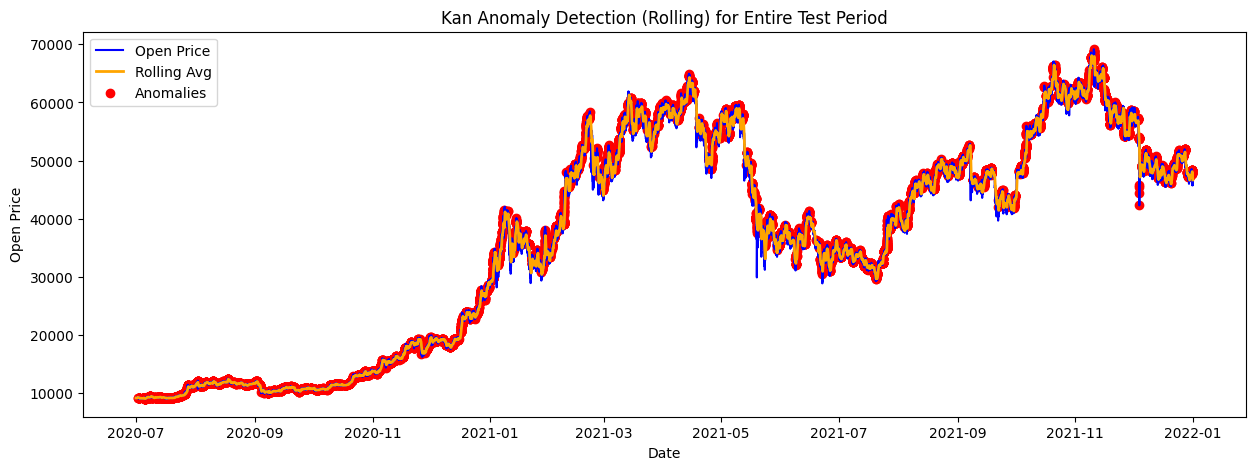


=== Statistics for Kan ===

Relative to 500-minutes Average:
relative_to_avg
Above Avg    9485
Below Avg    1958
Name: count, dtype: int64

Relative to 500-minutes Low/High:
relative_to_low_high
Above Low, Below High    8772
Above Low                2475
Below High                196
Name: count, dtype: int64

Next Hour Min/Max Open Price Change (%):
count    11443.000000
mean        -0.362470
std          0.885229
min        -11.648873
25%         -0.601732
50%         -0.267832
75%         -0.058831
max         12.584304
Name: price_change_pct_signed, dtype: float64

Next Hour Close Price Change (%):
count    11443.000000
mean        -0.059221
std          0.999655
min         -9.314376
25%         -0.444586
50%         -0.060566
75%          0.344572
max         12.852722
Name: close_change_pct_signed, dtype: float64


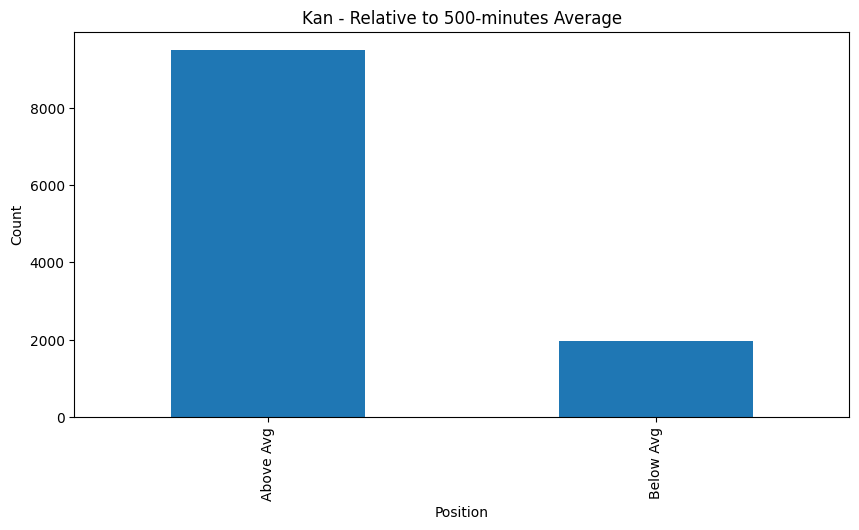

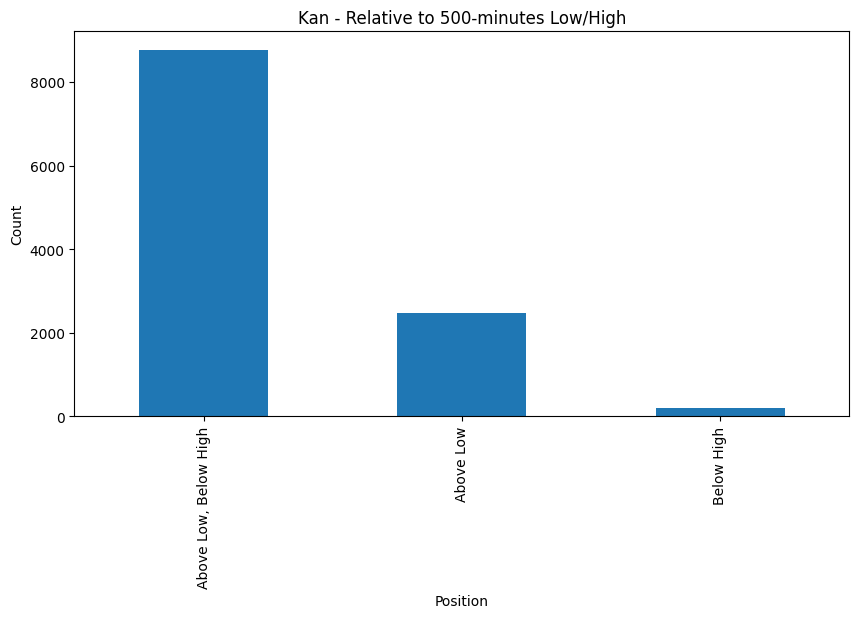

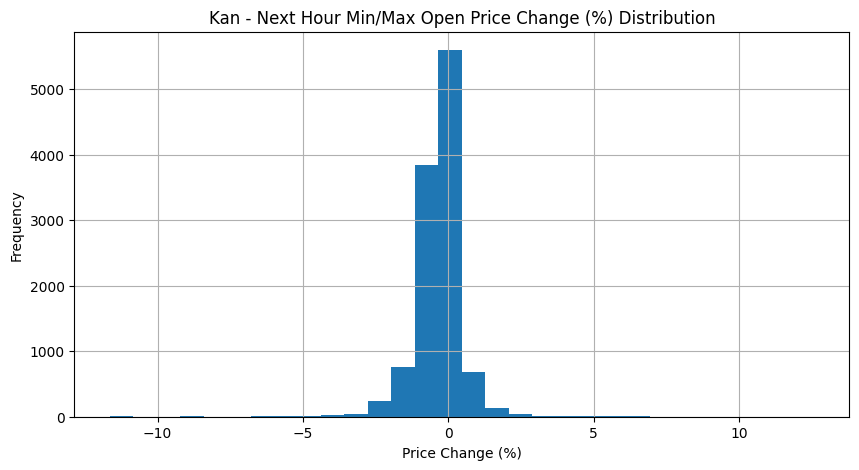

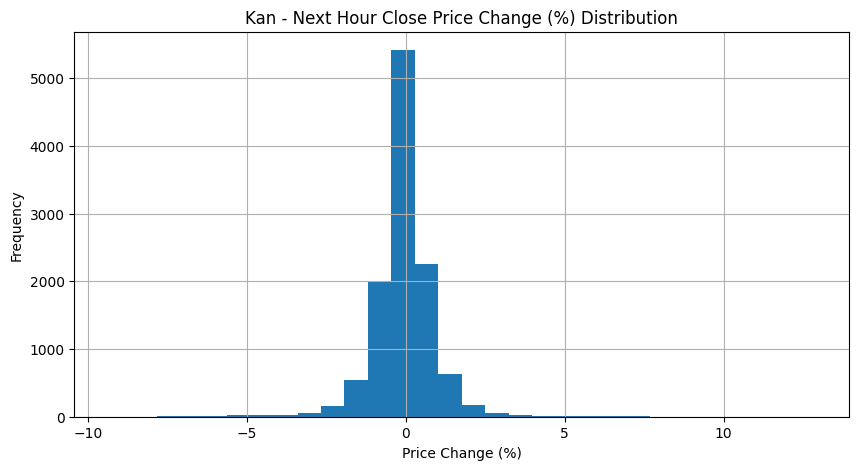

Trade executed: sell at 2020-07-02T06:08:00.000000000 (Entry Price: 9192.26), exited at 2020-07-02T06:09:00.000000000 (Exit Price: 9194.06), Volume: 0.2000, P&L: -0.0000
Trade executed: sell at 2020-07-02T06:11:00.000000000 (Entry Price: 9192.18), exited at 2020-07-02T06:12:00.000000000 (Exit Price: 9191.59), Volume: 0.2000, P&L: 0.0000
Trade executed: sell at 2020-07-02T15:01:00.000000000 (Entry Price: 9184.24), exited at 2020-07-02T15:02:00.000000000 (Exit Price: 9182.00), Volume: 0.2000, P&L: 0.0000
Trade executed: sell at 2020-07-02T15:02:00.000000000 (Entry Price: 9182.00), exited at 2020-07-02T15:03:00.000000000 (Exit Price: 9186.57), Volume: 0.2000, P&L: -0.0001
Trade executed: sell at 2020-07-02T15:03:00.000000000 (Entry Price: 9186.57), exited at 2020-07-02T15:04:00.000000000 (Exit Price: 9090.27), Volume: 0.2000, P&L: 0.0021
Trade executed: sell at 2020-07-02T15:04:00.000000000 (Entry Price: 9090.27), exited at 2020-07-02T15:05:00.000000000 (Exit Price: 9083.01), Volume: 0.20

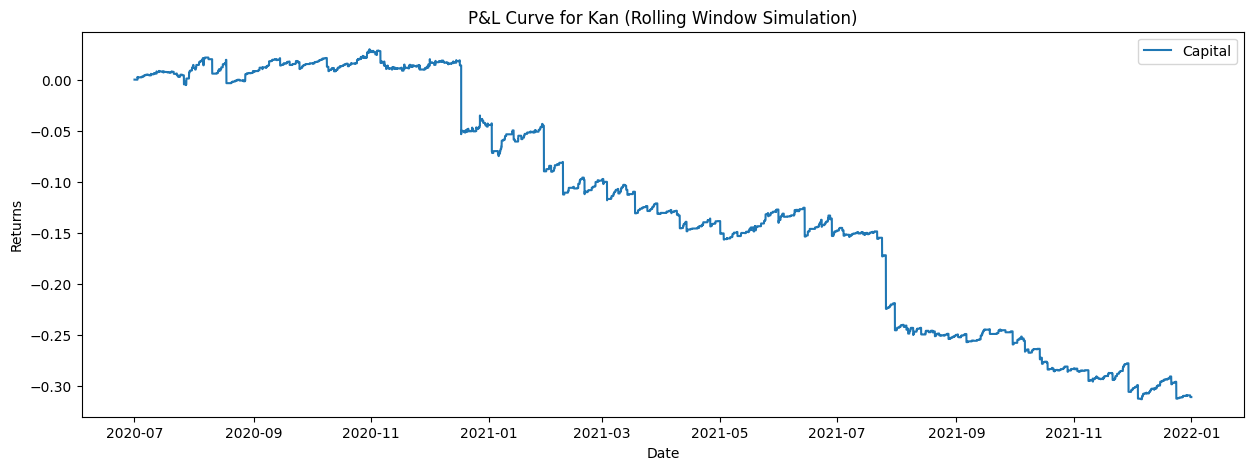

Final Capital for kan: 0.6889


In [110]:
for model_name in model_names:
    print(f"\n=== Final Outputs for Model: {model_name} ===")

    combined_scores[model_name] = np.array(combined_scores[model_name])
    scores = np.array(combined_scores[model_name])

    rolling_percentiles = np.zeros_like(scores, dtype=float) 
    rolling_anomalies   = np.zeros_like(scores, dtype=bool)  
    rolling_stds = np.zeros_like(scores, dtype=float) 

    for i in range(window_size_minutes, len(scores)):
        start_idx = i - window_size_minutes
        end_idx = i  
        window_slice = scores[start_idx:end_idx]  

        current_score = scores[i]

        if mode == 'percentile' or 'std':
            rank = percentileofscore(window_slice, current_score, kind='rank')
            rolling_percentiles[i] = rank  
    
            if rank >= percentile:
                rolling_anomalies[i] = True
        elif mode == 'std':
            deviation = deviation_from_mean(window_slice[-99:], current_score)
            rolling_stds[i] = deviation  
            
            if deviation >= num_std:
                rolling_anomalies[i] = True
        else:
            raise ValueError("Mode should be 'std' of 'percentile'")
            

    anomaly_dates = np.array(combined_test_dates)[rolling_anomalies]
    print(f"Found {rolling_anomalies.sum()} anomalies using rolling percentile = {percentile}")

    plt.figure(figsize=(15, 5))
    unscaled_prices = np.array(original_prices_buffer)
    plt.plot(combined_test_dates, unscaled_prices, label='Open Price', color='blue')

    rolling_avg_values = original_data_sorted['rolling_avg'].reindex(combined_test_dates).values
    plt.plot(combined_test_dates, rolling_avg_values, label='Rolling Avg', color='orange', linewidth=2)

    anomaly_prices = unscaled_prices[rolling_anomalies]
    plt.scatter(anomaly_dates, anomaly_prices, color='red', label='Anomalies')
    plt.title(f'{model_name.capitalize()} Anomaly Detection (Rolling) for Entire Test Period')
    plt.xlabel('Date')
    plt.ylabel('Open Price')
    plt.legend()
    plt.show()

    analysis_results = analyze_anomalies(anomaly_dates, original_data_sorted, window_minutes=window_minutes)
    compute_statistics(analysis_results, model_name)

    ma_window = window_minutes
    original_data_sorted['MA'] = original_data_sorted['close'].rolling(window=ma_window, min_periods=1).mean()
    
    combined_test_data = original_data_sorted.loc[combined_test_dates, 'close']
    combined_ma_data = original_data_sorted.loc[combined_test_dates, 'MA']

    if mode == 'percentile':
        capital_history = simulate_trading_percentile(
            model_name=model_name,
            price_data=original_data_sorted.loc[combined_test_dates, 'close'],
            ma_data=original_data_sorted.loc[combined_test_dates, 'MA'],
            scores=scores,
            rolling_percentiles=rolling_percentiles,  
            rolling_anomalies=rolling_anomalies,      
            percentile=percentile,
            max_entries=max_entries,
        )
    elif mode == 'std':
        capital_history = simulate_trading_std(
            model_name=model_name,
            price_data=original_data_sorted.loc[combined_test_dates, 'close'],
            rsi_data=original_data_sorted.loc[combined_test_dates, 'MA'],
            scores=scores,
            rolling_anomalies=rolling_anomalies,      
            num_std=num_std,
            max_entries=max_entries,
            distr_len=99
        )

    plt.figure(figsize=(15, 5))
    plt.plot(capital_history.index, capital_history.values - 1, label='Capital')
    plt.title(f'P&L Curve for {model_name.capitalize()} (Rolling Window Simulation)')
    plt.xlabel('Date')
    plt.ylabel('Returns')
    plt.legend()
    plt.show()

    final_capital = capital_history.iloc[-1]
    print(f"Final Capital for {model_name}: {final_capital:.4f}")

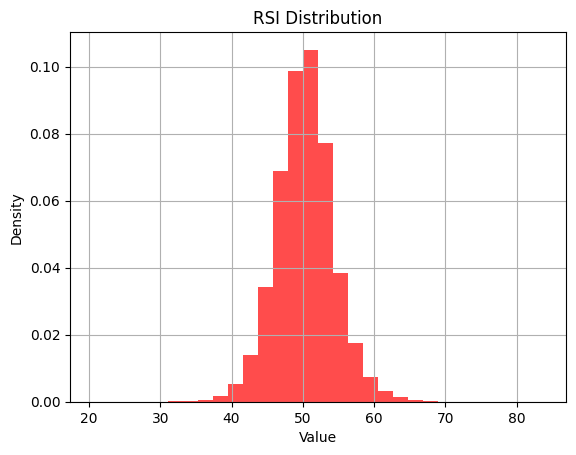

In [23]:
original_data_sorted.loc[combined_test_dates, 'rsi'].hist(bins=30, density=True, alpha=0.7, color='red')
plt.title('RSI Distribution')
plt.xlabel('Value')
plt.ylabel('Density')
plt.show()

In [96]:
def plot_true_vs_predicted(unscaled_prices, combined_test_dates, benchmark_extreme_regions, anomaly_dates, num_windows=3, window_duration="1D"):
    if not isinstance(window_duration, pd.Timedelta):
        window_duration = pd.Timedelta(window_duration)
    
    df = pd.DataFrame({"datetime": combined_test_dates, "price": unscaled_prices})
    df.set_index("datetime", inplace=True)
    
    full_start = df.index[0]
    full_end = df.index[-1]

    valid_start_indices = [i for i, t in enumerate(df.index) if t + window_duration <= full_end]

    if len(valid_start_indices) >= num_windows:
        selected_start_indices = random.sample(valid_start_indices, num_windows)
    else:
        selected_start_indices = valid_start_indices

    selected_start_indices.sort()
    selected_start_indices = [combined_test_dates.index(pd.Timestamp('2020-12-06 03:05:00'))]
    for start_idx in selected_start_indices:
        window_start = df.index[start_idx]
        window_end = window_start + window_duration
        window_df = df.loc[window_start:window_end]

        fig, ax = plt.subplots(figsize=(12, 6))
        ax.plot(window_df.index, window_df["price"], label="Price", color="black", linewidth=1)

        label_true = label_predicted = False

        # True anomalies (benchmark extreme regions)
        for start_idx, end_idx, _ in benchmark_extreme_regions:
            region_start, region_end = combined_test_dates[start_idx], combined_test_dates[end_idx]
            if region_end >= window_start and region_start <= window_end:
                plot_start = max(region_start, window_start)
                plot_end = min(region_end, window_end)
                if not label_true:
                    ax.axvspan(plot_start, plot_end, color="blue", alpha=0.3, label="True Anomaly (Benchmark)")
                    label_true = True
                else:
                    ax.axvspan(plot_start, plot_end, color="blue", alpha=0.3)

        # Predicted anomalies
        window_pred_anomalies = [t for t in anomaly_dates if window_start <= t <= window_end]
        for t in window_pred_anomalies:
            if not label_predicted:
                ax.axvline(t, color="red", linestyle="--", alpha=0.8, label="Predicted Anomaly")
                label_predicted = True
            else:
                ax.axvline(t, color="red", linestyle="--", alpha=0.8)

        ax.set_title(f"Comparison: {window_start} to {window_end}")
        ax.set_xlabel("Datetime")
        ax.set_ylabel("Price")
        ax.legend()
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

In [101]:
benchmark_extreme_regions = mark_extreme_regions(
    list(unscaled_prices), 
    threshold_abs=0.0, 
    threshold_pct=0.03, 
    use_pct=False, 
    dynamic_threshold=True, 
    vol_window=55, 
    vol_multiplier=80.0, 
    confirmation_period=2, 
    region_tolerance_pct=0.01
)

benchmark_anomaly_dates = set()
for start_idx, end_idx, _ in benchmark_extreme_regions:
    benchmark_anomaly_dates.update(combined_test_dates[start_idx:end_idx + 1])

from sklearn.metrics import precision_score, recall_score, f1_score

# Convert to sets for comparison
model_anomalies = set(anomaly_dates)
true_anomalies = benchmark_anomaly_dates

# Define True Positives, False Positives, and False Negatives
tp = len(model_anomalies & true_anomalies)  # Intersection
fp = len(model_anomalies - true_anomalies)  # In model but not in benchmark
fn = len(true_anomalies - model_anomalies)  # In benchmark but not in model

# Precision, Recall, F1
precision = tp / (tp + fp) if (tp + fp) > 0 else 0
recall = tp / (tp + fn) if (tp + fn) > 0 else 0
f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
iou = len(model_anomalies & true_anomalies) / len(model_anomalies | true_anomalies) if len(model_anomalies | true_anomalies) > 0 else 0
print(f"IoU (Jaccard Index): {iou:.4f}")


Precision: 0.9878
Recall: 0.0146
F1 Score: 0.0287
IoU (Jaccard Index): 0.0146


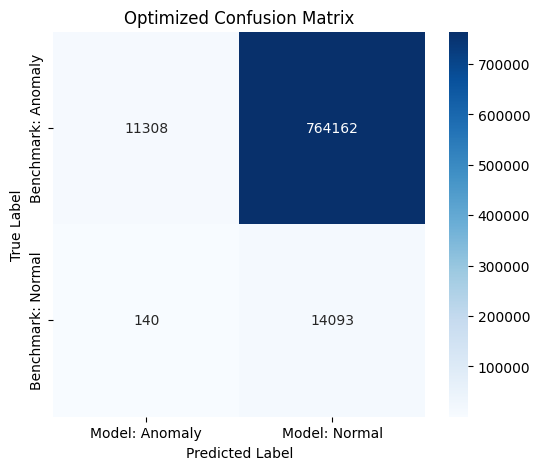

True Positives (TP): 11308
False Positives (FP): 140
False Negatives (FN): 764162
True Negatives (TN): 14093


In [102]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Define the full set of timestamps
benchmark_set = set(benchmark_anomaly_dates)
model_set = set(anomaly_dates)
all_set = set(combined_test_dates)

tp = len(model_set & benchmark_set)  
fp = len(model_set - benchmark_set)  
fn = len(benchmark_set - model_set)  
tn = len(all_set - (benchmark_set | model_set))  

cm = np.array([[tp, fn], [fp, tn]])

# Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Model: Anomaly", "Model: Normal"],
            yticklabels=["Benchmark: Anomaly", "Benchmark: Normal"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Optimized Confusion Matrix")
plt.show()

# Print values
print(f"True Positives (TP): {tp}")
print(f"False Positives (FP): {fp}")
print(f"False Negatives (FN): {fn}")
print(f"True Negatives (TN): {tn}")

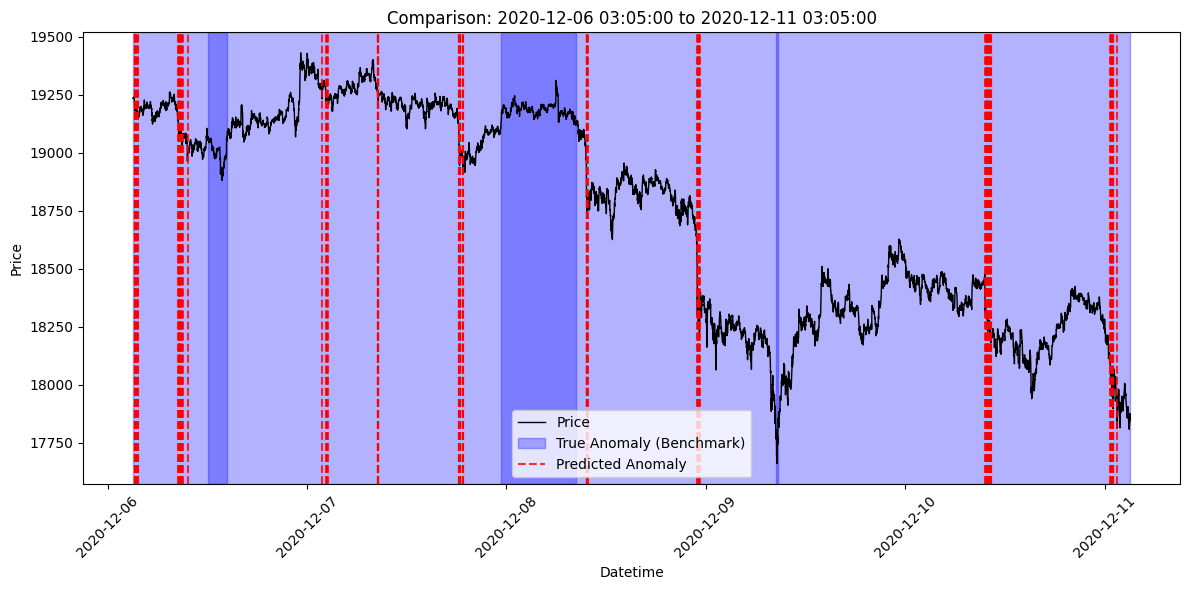

In [103]:
plot_true_vs_predicted(
    unscaled_prices, 
    combined_test_dates, 
    benchmark_extreme_regions, 
    anomaly_dates, 
    num_windows=3, 
    window_duration="5D"
)

In [69]:
print(len(benchmark_anomaly_dates))

11825


In [95]:
print(type(combined_test_dates[0]))

<class 'pandas._libs.tslibs.timestamps.Timestamp'>
